# Exploratory Analysis on Multi-Modal Traffic Patterns

Here I investigate how weather may affect choices for what type of transportation people choose. In this case, I choose to investigate an area with many transportation options. Lakeview, Chicago, is serviced by the Red, Brown, and Purple "EL" lines of the CTA, many bus routes, an extensive bike share network (DIVVY), as well as some bike lanes. Data was collected for only calendar year **2018**.

Data here was collected from a number of sources:

NOAA Weather Data
https://www.ncdc.noaa.gov/cdo-web/datatools/lcd

Chicago Historical Congestion Estimates
https://data.cityofchicago.org/dataset/Chicago-Traffic-Tracker-Historical-Congestion-Esti/kf7e-cur8


In [247]:
import pandas as pd
from sodapy import Socrata

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib as mpl
import matplotlib.dates as mdates

%matplotlib inline



## Traffic Data

The city of chicago maintains historical traffic estimates based upon bus speeds throughout the city. I here specifically request data for only a single region in chicago to simplify the data (Lakeview, Chicago). 

In [ ]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofchicago.org", None)



In [219]:
# Gather Traffic Data from Chicago city data
results = client.get("kf7e-cur8", where="region_id = 8 and time > \'2018-01-01T00:00:00\'", order="time DESC", limit=1000000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [323]:
# Change dataframe types to be more workable
results_df['time'] = pd.to_datetime(results_df['time'])
column_f_names = ['speed']
column_i_names = ['bus_count', 'day_of_week', 'hour', 'month']
results_df[column_i_names] = results_df[column_i_names].astype(int)
results_df[column_f_names] = results_df[column_f_names].astype(float)

#add columns for day of month and year, in addition to the already existing hour and month
results_df['day'] = results_df['time'].dt.day
results_df['year'] = results_df['time'].dt.year

### Daily traffic cycles

Just to see how variable traffic is throughout the day, and day to day, I plotted traffic speeds over time for the last week.

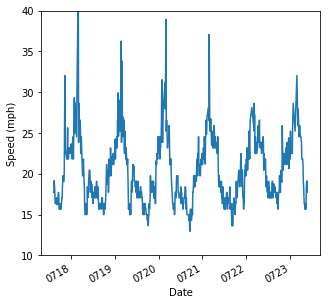

In [322]:
new_results_df = results_df[results_df['speed'] > 1]
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(new_results_df['time'][:750], new_results_df['speed'][:750])

myFmt = mdates.DateFormatter('%m%d')
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel('Date')
ax.set_ylabel('Speed (mph)')
ax.set_ylim(10,40)
fig.autofmt_xdate()
plt.savefig('recent_traffic.png')

Traffic data can be reported more than once per hour. Here, I average the reported speeds every hour.

In [224]:
traffic_df = results_df.groupby(['year', 'month', 'day', 'hour']).mean().reset_index()

## Weather Data

Weather was acquired from the NOAA for the weather station at O'hare International Airport (ORD). The data is collected hourly, with temperature, wind, and precipitation readings (as well as others). The data was downloaded from the website into a csv for calendar year 2018.

In [453]:
# Read csv into a pandas data frame
weather_df_all = pd.read_csv(
    '1408206.csv', 
    index_col=None, 
    na_values=['NA'])

/Users/morris/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (25,44,45,63,64,67,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [454]:
# only need temperature and date/time for now.
weather_df = weather_df_all[['HOURLYDRYBULBTEMPF', 'DATE']].rename(
    columns={'DATE': 'Time', 'HOURLYDRYBULBTEMPF':'Temp'})
weather_df = weather_df[np.isfinite(weather_df['Temp'])]

In [455]:
# add in columns for day, month, hour, year
weather_df['Time'] = pd.to_datetime(weather_df['Time'])
weather_df['day'] = weather_df['Time'].dt.day
weather_df['month'] = weather_df['Time'].dt.month
weather_df['hour'] = weather_df['Time'].dt.hour
weather_df['year'] = weather_df['Time'].dt.year

## Merging weather and traffic data

Now that the data for weather and traffic have been imported, merge the two dataframes so that we have traffic and weather for each hour in year 2018.

In [434]:

merge = pd.merge(weather_df, traffic_df, 
        on=['year', 'month', 'day', 'hour'])

### Traffic data vs temperature

A simple way to see how weather affects traffic speeds is just to make a histogram of traffic speeds vs temperature. Here, I use the numpy and matplotlib to construct this plot.

In [435]:
# edges for histogram
xedges = np.arange(10,110, 10)
yedges = np.arange(0, 37, 2)
xbinsize = xedges[1] - xedges[0]
ybinsize = yedges[1] - yedges[0]

H, xedges, yedges = np.histogram2d(merge['Temp'], merge['speed'], bins=(xedges, yedges), normed=False)
H = H.T  # Let each row list bins with common y range.

#Normalize for each temperature value
for i in range(len(H[0])):
    if np.sum(H[:,i]) > 0:
        H[:,i] /= (np.sum(H[:,i]) * ybinsize)

In [436]:
means = []
for i, x in enumerate(xedges[:-1]):
    means.append(merge[(merge.Temp > x) & (merge.Temp <= xedges[i+1]) ].speed.mean())

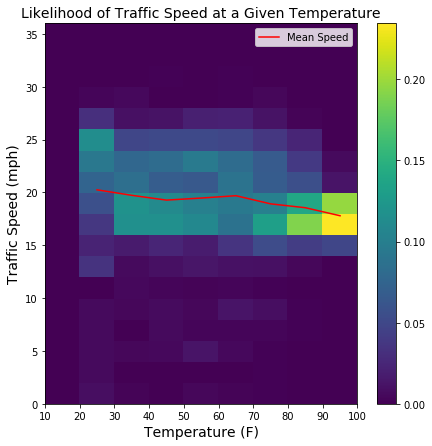

In [437]:
bigfont = 14
X, Y = np.meshgrid(xedges, yedges)

fig, ax = plt.subplots(figsize=(7, 7)) 
plt.pcolormesh(X, Y, H)
plt.title('Likelihood of Traffic Speed at a Given Temperature', fontsize=bigfont)
plt.plot(xedges[:-1] + (xbinsize/2.0), means, 'r-', label = 'Mean Speed')
ax.set_xlabel('Temperature (F)', fontsize=bigfont)
ax.set_ylabel('Traffic Speed (mph)', fontsize=bigfont)
plt.legend()
# set the limits of the plot to the limits of the data
#plt.axis([x.min(), x.max(), y.min(), y.max()])
plt.colorbar()
plt.savefig('traffic_vs_temp.png')

## Divvy Bike Data

Below, I gather data on divvy bike trips for a few bike stations in the same neighborhood and compare to weather data.

The first part is to find which divvy stations are within the neighborhood

In [335]:
east = results_df.iloc[0]['east']
west = results_df.iloc[0]['west']
north = results_df.iloc[0]['north']
south = results_df.iloc[0]['south']



In [ ]:
results_divvy_stations = client.get("67g3-8ig8", limit=2000)

# Convert to pandas DataFrame
divvy_stations_df = pd.DataFrame.from_records(results_divvy_stations)


Select a subset of 5 divvy stations within the neighborhood

In [420]:

random_5_divvy_stations = divvy_stations_df[(divvy_stations_df.longitude < west) & 
                  (divvy_stations_df.longitude > east) &
                  (divvy_stations_df.latitude > south) & 
                  (divvy_stations_df.latitude < north)]['id'].sample(n=5)

In [452]:
# make a string for the SoQL request

request_string = "start_time > \'2017-01-01T00:00:00.000\' and ("
for i in random_5_divvy_stations:
    request_string += "from_station_id = \'%d\' or " % int(i)
request_string = request_string[:-4] + ")"


Get the divvy results for through the API.

In [422]:
results_divvy = client.get("fg6s-gzvg", where=request_string, order="start_time DESC", limit=100000)

# Convert to pandas DataFrame
divvy_df_all = pd.DataFrame.from_records(results_divvy)

In [423]:
#Same as for the previous datasets, make columns for day, month, etc.
divvy_df = divvy_df_all[['from_station_id', 'start_time']].rename(
    columns={'start_time': 'Time', 'from_station_id':'from_station_id'})
divvy_df['Time'] = pd.to_datetime(divvy_df['Time'])
divvy_df['day'] = divvy_df['Time'].dt.day
divvy_df['month'] = divvy_df['Time'].dt.month
divvy_df['hour'] = divvy_df['Time'].dt.hour
divvy_df['year'] = divvy_df['Time'].dt.year

In [438]:
# get the number of bike trips at each hour throughout the year
divvy_df_counts = divvy_df.groupby(['year', 'month', 'day', 'hour']).count().reset_index().rename(
    columns={'from_station_id': 'bike_counts'})

### Bike data versus temperature

In [456]:
#merge the dataframes of weather and divvy, and create a histogram
merge_d = pd.merge(weather_df, divvy_df_counts, 
        on=['year', 'month', 'day', 'hour'])

# edges for histogram
xedges_d = np.arange(10,110, 10)
yedges_d = np.arange(0, 37, 1)
xbinsize_d = xedges[1] - xedges_d[0]
ybinsize_d = yedges[1] - yedges_d[0]

H_divvy, xedges_d, yedges_d = np.histogram2d(
    merge_d['Temp'], 
    merge_d['bike_counts'], 
    bins=(xedges_d, yedges_d), 
    normed=False)
H_divvy = H_divvy.T  # Let each row list bins with common y range.

#Normalize for each temperature value
for i in range(len(H_divvy[0])):
    if np.sum(H_divvy[:,i]) > 0:
        H_divvy[:,i] /= (np.sum(H_divvy[:,i]) * ybinsize_d)

In [457]:
divvy_means = []
for i, x in enumerate(xedges_d[:-1]):
    divvy_means.append(merge_d[(merge_d.Temp > x) & (merge_d.Temp <= xedges[i+1]) ].bike_counts.mean())

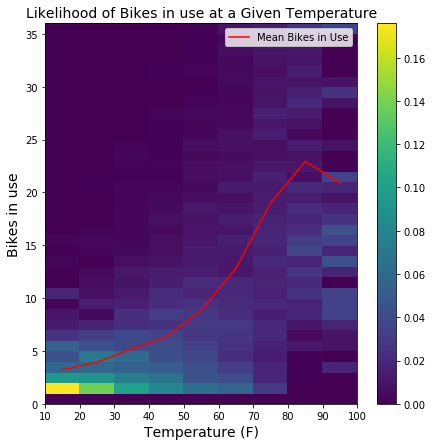

In [459]:
bigfont = 14
X_d, Y_d = np.meshgrid(xedges_d, yedges_d)

fig, ax = plt.subplots(figsize=(7, 7)) 
plt.pcolormesh(X_d, Y_d, H_divvy)
plt.title('Likelihood of Bikes in use at a Given Temperature', fontsize=bigfont)
plt.plot(xedges[:-1] + (xbinsize/2.0), divvy_means, 'r-', label = 'Mean Bikes in Use')
ax.set_xlabel('Temperature (F)', fontsize=bigfont)
ax.set_ylabel('Bikes in use', fontsize=bigfont)
plt.legend()
# set the limits of the plot to the limits of the data
#plt.axis([x.min(), x.max(), y.min(), y.max()])
plt.colorbar()
plt.savefig('bike_usage.png')

In [460]:
results_df.to_pickle('traffic.pickle')
weather_df_all.to_pickle('weather.pickle')
divvy_df_all.to_pickle('divvy.picle')